In [1]:
import tensorflow as tf
import numpy as np
from parana.Model import Model
from parana.Layers import fc_layer
from parana.Layers import softmax_layer
from parana.optimizer import optimizer
from parana.optimizer import adamopt
from parana.Layers import conv_layer
from parana.parameter_saver import saver
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True, reshape=False)
from IPython.display import clear_output
import pickle
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)
from parana.parameter_pruning import lobotomizer
from parana.layer_wiggles import get_mean_activations
from parana.wiggles import get_absolute_values
from parana.parameter_selection import get_k_smallest

path = 'path'

noise = tf.Variable(tf.zeros([28,28,1]), name='x_noise')
set_zero_noise = tf.assign(noise, tf.zeros([28,28,1]))
noise_placeholder = tf.placeholder('float', [28, 28,1], name = 'noise_placeholder')
assign_noise = tf.assign(noise, noise_placeholder)

class this_model(Model):
    
    def __init__(self, inputs, labels):
        self.inputs = inputs
        self.labels = labels
        self.cost_function = 'quadratic_l2'
        self.logit_cost_function = 'quadratic_l2'
        self.dropout = 0.7
        self.layers = [conv_layer(inputs = inputs + noise,
                                 height = 7, 
                                 width = 7, 
                                 filters = 12, 
                                 padding = 4, 
                                 stride = 1,
                                 flatten = False,
                                 weight_init = 'xavier',
                                 weight_decay=0.0001, bias_decay=0.0001)]
        self.layers.append(conv_layer(inputs = self.layers[0].activate,
                                 height = 5, 
                                 width = 5, 
                                 filters = 15, 
                                 padding = 2, 
                                 stride = 1,
                                 flatten = False,
                                 weight_init = 'xavier',
                                 weight_decay=0.0001, bias_decay=0.0001))
        self.layers.append(conv_layer(inputs = self.layers[1].activate,
                                 height = 3, 
                                 width = 3, 
                                 filters = 25, 
                                 padding = 1, 
                                 stride = 1,
                                 flatten = False,
                                 weight_init = 'xavier',
                                 weight_decay=0.0001, bias_decay=0.0001))
        self.layers.append(conv_layer(inputs = self.layers[2].activate,
                                 height = 3, 
                                 width = 3, 
                                 filters = 20, 
                                 padding = 1, 
                                 stride = 1,
                                 flatten = True,
                                 weight_init = 'xavier',
                                 weight_decay=0.0001, bias_decay=0.0001))
        self.layers.append(fc_layer(inputs = self.layers[3].activate,
                                   size = 1500,
                                   weight_init = 'xavier',
                                   weight_decay=0.0001, bias_decay=0.0001))
        self.layers.append(fc_layer(inputs=self.layers[4].activate, 
                               weight_init = 'xavier',
                               size=500, 
                               weight_decay=0.0001, bias_decay=0.0001))
        self.layers.append(softmax_layer(inputs=self.layers[5].activate, 
                                          size=10, 
                                          weight_decay=0.0001, bias_decay=0.0001))

X = tf.placeholder('float', [None, 28, 28, 1], name = 'Inputs')
y = tf.placeholder('float', [None, 10], name = 'Labels')   

sess = tf.Session()

mymodel = this_model(X, y)


model_saver = saver(mymodel, sess)

sess.run(tf.global_variables_initializer())


model_saver.load_parameters('{model.p'.format(path))
print('Model Loaded')
print(model_saver.split_accuracy(session = sess,
                       stages=20,
                       inputs = mnist.test.images, 
                       labels = mnist.test.labels))

C:\Users\Jim\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Populating the interactive namespace from numpy and matplotlib
Parameters loaded from  c:/users/jim/tensorflowtrials/cnn99.34%.p
Model Loaded
0.9934869766235351


# Helper functions that i have/had not added to parana package yet.

In [2]:
import matplotlib.pyplot as plt

#Gives a confidence measure for a list of outputs
def confidonk(slist):
    conn = []
    for i in slist:
        stort = np.sort(i)
        conn.append(stort[-1]/stort[-2])
    return conn

# Returns a list of T/F for confidence values below a cutoff
def isnoise(confidences, cutoff):
    return [int(abs(i) < cutoff) for i in confidences]

# Returns a list of T/F for whether outputs are correct
def iscorrect(outputs, labels):
    results = []
    for i in zip(outputs, labels):
        results.append(int(np.argmax(i[0]) == np.argmax(i[1])))
    return results

# Generates a set of half noisy images from the list of vectors, indices of vectors in vectorlist
#correspond to the class of the noise vector.
def noiseset(dataset, labels, vectorlist):
    # Adds noise to 50% of the datapoints, without adding noise of the same class as the datapoint. 
    datapoints = dataset.shape[0]
    gen = np.random.randint(2, size = datapoints)
    noisebatch = []
    classlist = []
    for i in range(datapoints):
        if gen[i] == 1:
            randclass = np.random.randint(len(vectorlist))
            while randclass == np.argmax(labels[i]):
                randclass = np.random.randint(len(vectorlist))
            classlist.append(randclass)
            noisebatch.append(np.clip(dataset[i] + vectorlist[randclass], 0,1))        
        else:
            noisebatch.append(dataset[i])
            classlist.append(None)
    return noisebatch, gen

def classify_outputs(outputs, labels, gen):
    noisecorrect = []
    noiseincorrect = []
    nonoisecorrect = []

    for i in range(datapoints):
        if gen[i] == 1:
            if np.argmax(labels[i]) == np.argmax(outputs[i]):
                noisecorrect.append(outputs[i])
            if np.argmax(labels[i]) != np.argmax(outputs[i]):
                noiseincorrect.append(outputs[i])
        if gen[i] == 0:
            if np.argmax(labels[i]) == np.argmax(outputs[i]):
                nonoisecorrect.append(outputs[i])
    return abs(np.array(noiseincorrect)), abs(np.array(noisecorrect)), abs(np.array(nonoisecorrect))

def plot_cutoff(incorrect_noise, correct_noise, no_noise, start, end, step):
    
    incorr_noise = []
    corr_noise = []
    cutoffs = []
    nonoise = []
    cutoff = start
    for i in range(int((end-start)/step)):
        incorr_noise.append(sum(incorrect_noise>cutoff)/len(incorrect_noise))
        corr_noise.append(sum(correct_noise>cutoff)/len(correct_noise))
        nonoise.append(sum(no_noise>cutoff)/len(no_noise))
        cutoffs.append(cutoff)
        cutoff += step
    return incorr_noise,corr_noise, nonoise, cutoffs


In [3]:
absvalues = lobotomizer(session = sess,
                          model = mymodel,
                          parameters_list = mymodel.get_weights[4:],
                          wigglyness = get_absolute_values,
                          parameter_selection = get_k_smallest,
                          cost = mymodel.cost,
                          data_function = mnist.train.next_batch,
                          X = X, y = y)
activationvalues = lobotomizer(session = sess,
                               model = mymodel,
                               parameters_list = mymodel.get_weights[4:],
                               layers_list = mymodel.layers[4:],
                               wigglyness = get_mean_activations,
                               parameter_selection = get_k_smallest,
                               cost = mymodel.cost,
                               data_function = mnist.train.next_batch,
                               X = X, y = y)
activationvalues.get_wigglyness(iterations = 2000)
print('gotit')

gotit


In [4]:
model_saver.restore_parameters()
path = 'path'

smallnoise = ['{}adv_class_0_limit_0.15.p', '{}adv_class_1_limit_0.2.p', '{}adv_class_2_limit_0.15.p', 
             '{}adv_class_3_limit_0.2.p', '{}adv_class_4_limit_0.2.p', '{}adv_class_5_limit_0.15.p']

bignoise = ['{}adv_class_0_limit_0.35.p', '{}adv_class_1_limit_0.25.p', '{}adv_class_2_limit_0.25.p', 
             '{}adv_class_3_limit_0.3.p', '{}adv_class_4_limit_0.25.p', '{}adv_class_5_limit_0.35.p']

# Plot CDFs of confidence estimates

Test accuracy without noise
0.9935
Batch accuracy with noise
0.8227


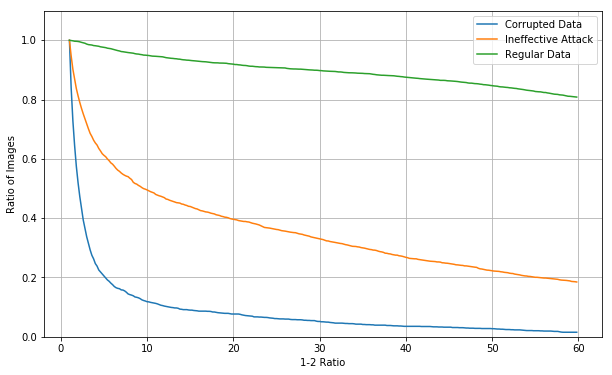

30.999999999999922
0.04951622083096187
0.8956626024385369


In [37]:

noiselist = [pickle.load(open(i.format(path), 'rb')) for i in bignoise]

mymodel.zerodropout
model_saver.restore_parameters()

print('Test accuracy without noise')
print(mymodel.accuracy(sess,inputs =  mnist.test.images, labels =  mnist.test.labels))

datapoints = 10000
batch = mnist.train.next_batch(datapoints)

noisebatch, gen = noiseset(batch[0], batch[1], noiselist)

print('Batch accuracy with noise')
print(mymodel.accuracy(sess,inputs =  noisebatch, labels =  batch[1]))

outputs = (sess.run(mymodel.logitoutput, {X: noisebatch}))

incorrect_noise_confidence, correct_noise_confidence, no_noise_confidence = classify_outputs(outputs, batch[1], gen)
incorrect_noise_confidence = np.array(confidonk(incorrect_noise_confidence))
correct_noise_confidence = np.array(confidonk(correct_noise_confidence))
no_noise_confidence = np.array(confidonk(no_noise_confidence))


badnoise,somenoise, goodnoise, cutoffs = plot_cutoff(incorrect_noise_confidence, correct_noise_confidence,
                                 no_noise_confidence,
                                 start = 1, end = 60, step = 0.2)

plt.plot(cutoffs, badnoise, label='Corrupted Data')
plt.plot(cutoffs, somenoise, label='Ineffective Attack')
plt.plot(cutoffs, goodnoise, label='Regular Data')
plt.ylim(0,1.1)
plt.xlabel('1-2 Ratio')
plt.ylabel('Ratio of Images')
plt.grid()
plt.legend()
plt.show()
plt.show()
print(cutoffs[150])
print(badnoise[150])
print(goodnoise[150])

In [38]:
model_saver.restore_parameters()
activationvalues.prune_step(0.96, layers_list = [mymodel.layers[4]])
activationvalues.prune_step(0.95, layers_list = [mymodel.layers[5]])

Test accuracy without noise
0.9912
Batch accuracy with noise
0.8394


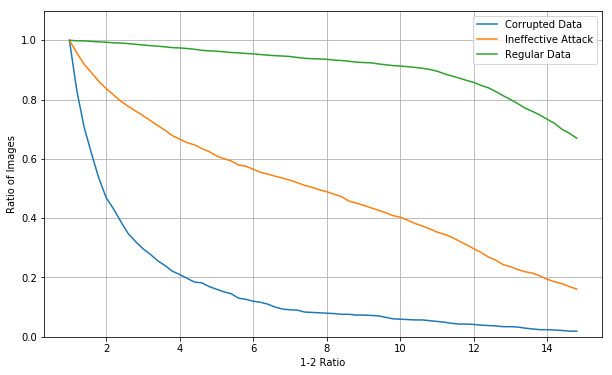

10.199999999999996
0.05815423514538559
0.9110204081632653


In [39]:
mymodel.zerodropout

noiselist = [pickle.load(open(i.format(path), 'rb')) for i in bignoise]

print('Test accuracy without noise')
print(mymodel.accuracy(sess,inputs =  mnist.test.images, labels =  mnist.test.labels))

datapoints = 5000
batch = mnist.train.next_batch(datapoints)

noisebatch, gen = noiseset(batch[0], batch[1], noiselist)

print('Batch accuracy with noise')
print(mymodel.accuracy(sess,inputs =  noisebatch, labels =  batch[1]))

outputs = (sess.run(mymodel.logitoutput, {X: noisebatch}))

incorrect_noise_confidence, correct_noise_confidence, no_noise_confidence = classify_outputs(outputs, batch[1], gen)
incorrect_noise_confidence = np.array(confidonk(incorrect_noise_confidence))
correct_noise_confidence = np.array(confidonk(correct_noise_confidence))
no_noise_confidence = np.array(confidonk(no_noise_confidence))


badnoise,somenoise, goodnoise, cutoffs = plot_cutoff(incorrect_noise_confidence, correct_noise_confidence,
                                 no_noise_confidence,
                                 start = 1, end = 15, step = 0.2)

plt.plot(cutoffs, badnoise, label='Corrupted Data')
plt.plot(cutoffs, somenoise, label='Ineffective Attack')
plt.plot(cutoffs, goodnoise, label='Regular Data')
plt.xlabel('1-2 Ratio')
plt.ylabel('Ratio of Images')
plt.ylim(0,1.1)
plt.grid()
plt.legend()
plt.show()
plt.show()
print(cutoffs[46])
print(badnoise[46])
print(goodnoise[46])

# High and low confidence images

In [12]:
#labels = mnist.test.labels
#images = mnist.test.images

batch = mnist.train.next_batch(5000)
images = batch[0]
labels = batch[1]

outputs = sess.run(mymodel.logitoutput, {X:images})
correct = []
correct_images = []
incorrect = []
incorrect_images = []
incorrect_labels = []

#Split into correct and incorrect
for i in range(len(outputs)):
    if np.argmax(outputs[i]) == np.argmax(labels[i]):
        correct.append(outputs[i])
        correct_images.append(images[i])
    if np.argmax(outputs[i]) != np.argmax(labels[i]):
        incorrect.append(outputs[i])
        incorrect_labels.append(labels[i])
        incorrect_images.append(images[i])

correct_confidence = confidonk(correct)
incorrect_confidence = confidonk(incorrect)

# Indices of the lowest confidence images
correct_lowest_indices = np.argpartition(np.abs(correct_confidence), 9)[:9]
correct_highest_indices = np.argpartition(np.abs(correct_confidence), 9)[-9:]

low_confidence_images = ([correct_images[i] for i in correct_lowest_indices])
high_confidence_images = ([correct_images[i] for i in correct_highest_indices])

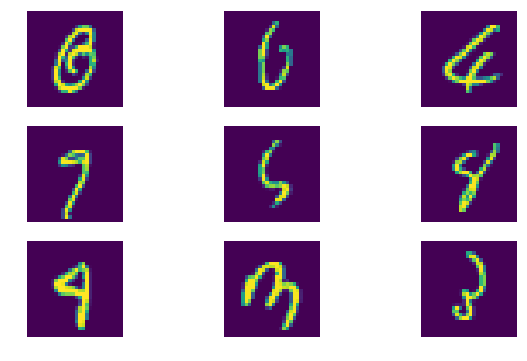

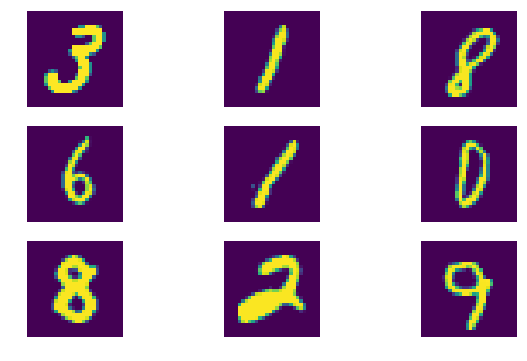

In [13]:

def plot_images(image_list):
    fig = plt.figure()
    for i in range(9):
        plt.subplot(331+i)
        plt.imshow(np.reshape(image_list[i], (28, 28)))
        plt.axis('off')
        
plot_images(low_confidence_images)
plot_images(high_confidence_images)